# Group 6: 
# Team Members: <br>  1. Jay Joshi <br>  2. Avirit Singh <br>  3. Varun Patil <br>  4. Vaibhavi Rao <br>  5. Pragya Priyadarshini <br>  6. Tanu datt 

# Preprocessing :- Done By Jay Joshi

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.ml.linalg import Vectors
from pyarrow import fs
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.types import (
    StructType, StructField, StringType, IntegerType, BooleanType, FloatType, ArrayType, MapType
)
from pyspark.ml.recommendation import ALS

In [2]:
PATH = "hdfs://localhost:9000/input/fashion-dataset"
# Create a Spark session
spark = SparkSession.builder \
    .appName("BD with Spark") \
    .getOrCreate()

# check if spark session is running
print(spark)

24/12/02 11:10:38 WARN Utils: Your hostname, IMS-028MBA.local resolves to a loopback address: 127.0.0.1; using 10.250.218.184 instead (on interface en0)
24/12/02 11:10:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/02 11:10:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
images_df = spark.read.csv(PATH+'/images.csv', header=True, inferSchema=True)
print(f"Number of rows in the DataFrame: {images_df.count()}")
images_df.show(5) 

Number of rows in the DataFrame: 44446
+---------+--------------------+
| filename|                link|
+---------+--------------------+
|15970.jpg|http://assets.myn...|
|39386.jpg|http://assets.myn...|
|59263.jpg|http://assets.myn...|
|21379.jpg|http://assets.myn...|
|53759.jpg|http://assets.myn...|
+---------+--------------------+
only showing top 5 rows



In [4]:
styles_df = spark.read.csv(PATH+'/styles.csv', header=True, inferSchema=True)
styles_df.show(5) 

+-----+------+--------------+-----------+-----------+----------+------+----+------+--------------------+
|   id|gender|masterCategory|subCategory|articleType|baseColour|season|year| usage|  productDisplayName|
+-----+------+--------------+-----------+-----------+----------+------+----+------+--------------------+
|15970|   Men|       Apparel|    Topwear|     Shirts| Navy Blue|  Fall|2011|Casual|Turtle Check Men ...|
|39386|   Men|       Apparel| Bottomwear|      Jeans|      Blue|Summer|2012|Casual|Peter England Men...|
|59263| Women|   Accessories|    Watches|    Watches|    Silver|Winter|2016|Casual|Titan Women Silve...|
|21379|   Men|       Apparel| Bottomwear|Track Pants|     Black|  Fall|2011|Casual|Manchester United...|
|53759|   Men|       Apparel|    Topwear|    Tshirts|      Grey|Summer|2012|Casual|Puma Men Grey T-s...|
+-----+------+--------------+-----------+-----------+----------+------+----+------+--------------------+
only showing top 5 rows



In [5]:
# Display the schema of the DataFrame
styles_df.printSchema()

# Count the number of rows
num_rows = styles_df.count()
print(f"Number of rows: {num_rows}")

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- masterCategory: string (nullable = true)
 |-- subCategory: string (nullable = true)
 |-- articleType: string (nullable = true)
 |-- baseColour: string (nullable = true)
 |-- season: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- usage: string (nullable = true)
 |-- productDisplayName: string (nullable = true)

Number of rows: 44446


In [6]:
# List of categorical columns
categorical_columns = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage']

# Count distinct values in each categorical column
for column in categorical_columns:
    distinct_count = styles_df.select(column).distinct().count()
    print(f"Number of unique values in '{column}': {distinct_count}")

Number of unique values in 'gender': 5
Number of unique values in 'masterCategory': 7
Number of unique values in 'subCategory': 45
Number of unique values in 'articleType': 143
Number of unique values in 'baseColour': 47
Number of unique values in 'season': 5
Number of unique values in 'usage': 10


In [7]:
# Show top 5 most common values for each categorical column
for column in categorical_columns:
    print(f"Most common values in '{column}':")
    styles_df.groupBy(column).count().orderBy(col("count").desc()).show(5)

Most common values in 'gender':
+------+-----+
|gender|count|
+------+-----+
|   Men|22165|
| Women|18632|
|Unisex| 2164|
|  Boys|  830|
| Girls|  655|
+------+-----+

Most common values in 'masterCategory':
+--------------+-----+
|masterCategory|count|
+--------------+-----+
|       Apparel|21400|
|   Accessories|11289|
|      Footwear| 9222|
| Personal Care| 2404|
|    Free Items|  105|
+--------------+-----+
only showing top 5 rows

Most common values in 'subCategory':
+-----------+-----+
|subCategory|count|
+-----------+-----+
|    Topwear|15405|
|      Shoes| 7344|
|       Bags| 3055|
| Bottomwear| 2694|
|    Watches| 2542|
+-----------+-----+
only showing top 5 rows

Most common values in 'articleType':
+------------+-----+
| articleType|count|
+------------+-----+
|     Tshirts| 7070|
|      Shirts| 3217|
|Casual Shoes| 2846|
|     Watches| 2542|
|Sports Shoes| 2036|
+------------+-----+
only showing top 5 rows

Most common values in 'baseColour':
+----------+-----+
|baseColour|

In [8]:
# Distribution by season
styles_df.groupBy("season").count().orderBy(col("count").desc()).show()

# Distribution by year
styles_df.groupBy("year").count().orderBy(col("year")).show()

+------+-----+
|season|count|
+------+-----+
|Summer|21476|
|  Fall|11445|
|Winter| 8519|
|Spring| 2985|
|  NULL|   21|
+------+-----+

+----+-----+
|year|count|
+----+-----+
|NULL|    1|
|2007|    2|
|2008|    7|
|2009|   20|
|2010|  846|
|2011|13689|
|2012|16290|
|2013| 1213|
|2014|  236|
|2015| 2780|
|2016| 6007|
|2017| 2917|
|2018|  405|
|2019|   33|
+----+-----+



In [9]:
# Count null values in each column
styles_df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in styles_df.columns]).show()

+---+------+--------------+-----------+-----------+----------+------+----+-----+------------------+
| id|gender|masterCategory|subCategory|articleType|baseColour|season|year|usage|productDisplayName|
+---+------+--------------+-----------+-----------+----------+------+----+-----+------------------+
|  0|     0|             0|          0|          0|         0|    21|   1|    1|                 0|
+---+------+--------------+-----------+-----------+----------+------+----+-----+------------------+



In [10]:
styles_df.groupBy("usage").count().orderBy(col("count").desc()).show()

+------------+-----+
|       usage|count|
+------------+-----+
|      Casual|34414|
|      Sports| 4025|
|      Ethnic| 3208|
|      Formal| 2359|
|          NA|  316|
|Smart Casual|   67|
|       Party|   29|
|      Travel|   26|
|        Home|    1|
|        NULL|    1|
+------------+-----+



In [11]:
styles_df.groupBy("gender", "articleType").count().orderBy(col("count").desc()).show(10)

+------+------------+-----+
|gender| articleType|count|
+------+------------+-----+
|   Men|     Tshirts| 5246|
|   Men|      Shirts| 2844|
|   Men|Casual Shoes| 2247|
| Women|      Kurtas| 1761|
| Women|    Handbags| 1689|
|   Men|Sports Shoes| 1590|
| Women|        Tops| 1532|
|   Men|     Watches| 1473|
| Women|       Heels| 1322|
| Women|     Tshirts| 1116|
+------+------------+-----+
only showing top 10 rows



In [12]:
styles_df.groupBy("baseColour").count().orderBy(col("count").desc()).show(10)

+----------+-----+
|baseColour|count|
+----------+-----+
|     Black| 9732|
|     White| 5540|
|      Blue| 4922|
|     Brown| 3494|
|      Grey| 2741|
|       Red| 2458|
|     Green| 2116|
|      Pink| 1861|
| Navy Blue| 1791|
|    Purple| 1643|
+----------+-----+
only showing top 10 rows



In [4]:
# Define the schema (same as in your original code)
image_resolutions_schema = StructType([
    StructField("X1080X1440Xmini", StringType(), True),
    StructField("X48X64", StringType(), True),
    StructField("X1080X1440", StringType(), True),
    StructField("X150X200", StringType(), True),
    StructField("X360X480", StringType(), True),
    StructField("X180X240", StringType(), True),
    StructField("X360X480Xmini", StringType(), True),
    StructField("X180X240Xmini", StringType(), True),
    StructField("X150X200Xmini", StringType(), True),
    StructField("X48X64Xmini", StringType(), True),
    StructField("X125X161", StringType(), True),
    StructField("X125X161Xmini", StringType(), True)
])

style_images_schema = StructType([
    StructField("imageURL", StringType(), True),
    StructField("resolutions", image_resolutions_schema, True),
    StructField("imageType", StringType(), True)
])

article_attributes_schema = StructType([
    StructField("Pattern", StringType(), True),
    StructField("Body_or_Garment_Size", StringType(), True)
])

cross_link_schema = StructType([
    StructField("key", StringType(), True),
    StructField("value", StringType(), True)
])

data_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("price", IntegerType(), True),
    StructField("discountedPrice", IntegerType(), True),
    StructField("styleType", StringType(), True),
    StructField("productTypeId", IntegerType(), True),
    StructField("articleNumber", StringType(), True),
    StructField("visualTag", StringType(), True),
    StructField("productDisplayName", StringType(), True),
    StructField("variantName", StringType(), True),
    StructField("myntraRating", IntegerType(), True),
    StructField("catalogAddDate", IntegerType(), True),
    StructField("brandName", StringType(), True),
    StructField("ageGroup", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("baseColour", StringType(), True),
    StructField("colour1", StringType(), True),
    StructField("colour2", StringType(), True),
    StructField("fashionType", StringType(), True),
    StructField("season", StringType(), True),
    StructField("year", StringType(), True),
    StructField("usage", StringType(), True),
    StructField("vat", FloatType(), True),
    StructField("displayCategories", StringType(), True),
    StructField("weight", StringType(), True),
    StructField("navigationId", IntegerType(), True),
    StructField("landingPageUrl", StringType(), True),
    StructField("articleAttributes", article_attributes_schema, True),
    StructField("crossLinks", ArrayType(cross_link_schema), True),
    StructField("brandUserProfile", StringType(), True),  # Empty object
    StructField("codEnabled", BooleanType(), True),
    StructField("styleImages", MapType(StringType(), style_images_schema), True)
])

meta_schema = StructType([
    StructField("code", IntegerType(), True),
    StructField("requestId", StringType(), True)
])

schema = StructType([
    StructField("notification", StringType(), True),  # Empty object
    StructField("meta", meta_schema, True),
    StructField("data", data_schema, True)
])

# Path to the directory containing your JSON files
json_files_path = PATH+'/styles/*.json'

# Read multiple JSON files into DataFrame with schema
df = spark.read.schema(schema).json(json_files_path)

# Show DataFrame and schema
df.printSchema()

root
 |-- notification: string (nullable = true)
 |-- meta: struct (nullable = true)
 |    |-- code: integer (nullable = true)
 |    |-- requestId: string (nullable = true)
 |-- data: struct (nullable = true)
 |    |-- id: integer (nullable = true)
 |    |-- price: integer (nullable = true)
 |    |-- discountedPrice: integer (nullable = true)
 |    |-- styleType: string (nullable = true)
 |    |-- productTypeId: integer (nullable = true)
 |    |-- articleNumber: string (nullable = true)
 |    |-- visualTag: string (nullable = true)
 |    |-- productDisplayName: string (nullable = true)
 |    |-- variantName: string (nullable = true)
 |    |-- myntraRating: integer (nullable = true)
 |    |-- catalogAddDate: integer (nullable = true)
 |    |-- brandName: string (nullable = true)
 |    |-- ageGroup: string (nullable = true)
 |    |-- gender: string (nullable = true)
 |    |-- baseColour: string (nullable = true)
 |    |-- colour1: string (nullable = true)
 |    |-- colour2: string (nulla

24/12/02 11:11:55 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
# Flatten the meta and data structs
flattened_df = df.select(
    col("notification"),
    col("meta.code").alias("meta_code"),
    col("meta.requestId").alias("meta_requestId"),
    col("data.id").alias("data_id"),
    col("data.price").alias("data_price"),
    col("data.discountedPrice").alias("data_discountedPrice"),
    col("data.styleType").alias("data_styleType"),
    col("data.productTypeId").alias("data_productTypeId"),
    col("data.articleNumber").alias("data_articleNumber"),
    col("data.visualTag").alias("data_visualTag"),
    col("data.productDisplayName").alias("data_productDisplayName"),
    col("data.variantName").alias("data_variantName"),
    col("data.myntraRating").alias("data_myntraRating"),
    col("data.catalogAddDate").alias("data_catalogAddDate"),
    col("data.brandName").alias("data_brandName"),
    col("data.ageGroup").alias("data_ageGroup"),
    col("data.gender").alias("data_gender"),
    col("data.baseColour").alias("data_baseColour"),
    col("data.colour1").alias("data_colour1"),
    col("data.colour2").alias("data_colour2"),
    col("data.fashionType").alias("data_fashionType"),
    col("data.season").alias("data_season"),
    col("data.year").alias("data_year"),
    col("data.usage").alias("data_usage"),
    col("data.vat").alias("data_vat"),
    col("data.displayCategories").alias("data_displayCategories"),
    col("data.weight").alias("data_weight"),
    col("data.navigationId").alias("data_navigationId"),
    col("data.landingPageUrl").alias("data_landingPageUrl"),
    col("data.articleAttributes.Pattern").alias("data_articleAttributes_Pattern"),
    col("data.articleAttributes.Body_or_Garment_Size").alias("data_articleAttributes_Body_or_Garment_Size"),
    col("data.crossLinks").alias("data_crossLinks"),
    col("data.brandUserProfile").alias("data_brandUserProfile"),
    col("data.codEnabled").alias("data_codEnabled"),
    col("data.styleImages").alias("data_styleImages")
)

# Show the flattened DataFrame Schema
flattened_df.printSchema()

root
 |-- notification: string (nullable = true)
 |-- meta_code: integer (nullable = true)
 |-- meta_requestId: string (nullable = true)
 |-- data_id: integer (nullable = true)
 |-- data_price: integer (nullable = true)
 |-- data_discountedPrice: integer (nullable = true)
 |-- data_styleType: string (nullable = true)
 |-- data_productTypeId: integer (nullable = true)
 |-- data_articleNumber: string (nullable = true)
 |-- data_visualTag: string (nullable = true)
 |-- data_productDisplayName: string (nullable = true)
 |-- data_variantName: string (nullable = true)
 |-- data_myntraRating: integer (nullable = true)
 |-- data_catalogAddDate: integer (nullable = true)
 |-- data_brandName: string (nullable = true)
 |-- data_ageGroup: string (nullable = true)
 |-- data_gender: string (nullable = true)
 |-- data_baseColour: string (nullable = true)
 |-- data_colour1: string (nullable = true)
 |-- data_colour2: string (nullable = true)
 |-- data_fashionType: string (nullable = true)
 |-- data_se

+--------------+------------------+
|data_brandName|         avg_price|
+--------------+------------------+
|        Suunto|           25450.0|
|  Just Cavalli|13963.888888888889|
|       Nautica|          9513.125|
|     Morellato|            9094.0|
|        SKAGEN|            8745.0|
+--------------+------------------+



<Axes: title={'center': 'Top 5 Brands by Average Price'}, xlabel='Brand', ylabel='Average Price'>

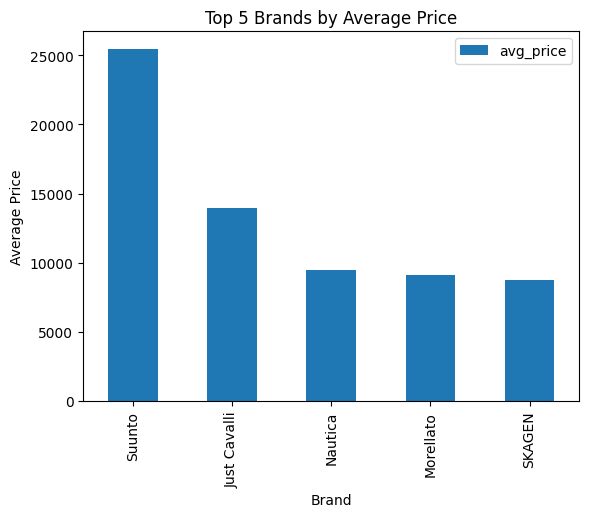

In [21]:
from pyspark.sql import functions as F

# Assuming 'flattened_df' is your PySpark DataFrame
# Group by brand name and calculate average price
top_brands = (
    flattened_df.groupBy("data_brandName")
    .agg(F.mean("data_price").alias("avg_price"))
    .orderBy(F.col("avg_price").desc())
    .limit(10)  # Get top 5 brands
)

# Show the top 5 brands (PySpark does not support direct plotting like pandas)
top_brands.show()

# If you need to plot this in an environment that supports plotting:
# Convert to Pandas DataFrame (for plotting, if necessary and the data is small enough)
pandas_df = top_brands.toPandas()

# Plot the top 5 brands using Pandas (this step would typically be done on a local machine or a notebook interface)
pandas_df.plot(kind="bar", x='data_brandName', y='avg_price', title="Top 5 Brands by Average Price", xlabel="Brand", ylabel="Average Price")


<Axes: title={'center': 'Top 5 Brands by Average Price'}, xlabel='Brand', ylabel='Average Price'>

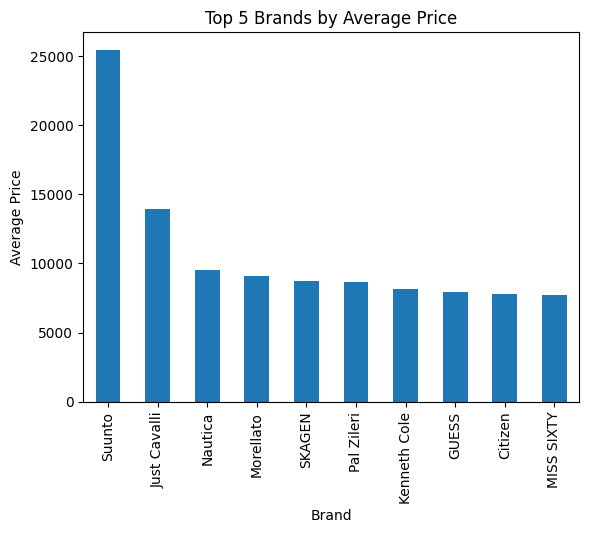

In [23]:
# Convert to Pandas DataFrame
pandas_df = flattened_df.toPandas()

# Group by brand name and calculate average price
top_brands = (
    pandas_df.groupby("data_brandName")["data_price"]
    .mean()
    .sort_values(ascending=False)
    .head(10)  # Get top 5 brands
)

# Plot the top 5 brands
top_brands.plot(kind="bar", title="Top 5 Brands by Average Price", xlabel="Brand", ylabel="Average Price")


In [6]:
# Drop unnecessary columns
cleaned_df = flattened_df.drop(
    "data_articleAttributes_Pattern",
    "data_articleAttributes_Body_or_Garment_Size","data_visualTag",
    "data_brandUserProfile","notification",
    "data_styleImages" ,
    "data_styleImages"
)

# Show the updated DataFrame
cleaned_df.printSchema()

root
 |-- meta_code: integer (nullable = true)
 |-- meta_requestId: string (nullable = true)
 |-- data_id: integer (nullable = true)
 |-- data_price: integer (nullable = true)
 |-- data_discountedPrice: integer (nullable = true)
 |-- data_styleType: string (nullable = true)
 |-- data_productTypeId: integer (nullable = true)
 |-- data_articleNumber: string (nullable = true)
 |-- data_productDisplayName: string (nullable = true)
 |-- data_variantName: string (nullable = true)
 |-- data_myntraRating: integer (nullable = true)
 |-- data_catalogAddDate: integer (nullable = true)
 |-- data_brandName: string (nullable = true)
 |-- data_ageGroup: string (nullable = true)
 |-- data_gender: string (nullable = true)
 |-- data_baseColour: string (nullable = true)
 |-- data_colour1: string (nullable = true)
 |-- data_colour2: string (nullable = true)
 |-- data_fashionType: string (nullable = true)
 |-- data_season: string (nullable = true)
 |-- data_year: string (nullable = true)
 |-- data_usage: s

In [7]:
trends_df = cleaned_df.groupBy("data_season", "data_year", "data_baseColour").count()
trends_df.show()

+-----------+---------+---------------+-----+
|data_season|data_year|data_baseColour|count|
+-----------+---------+---------------+-----+
|       Fall|     2012|      Navy Blue|   64|
|     Winter|     2017|          Black|    3|
|     Summer|     2012|      Navy Blue|  586|
|     Summer|     2012|         Purple|  474|
|       Fall|     2018|          White|    3|
|       Fall|     2011|           Blue| 1338|
|     Winter|     2012|   Coffee Brown|    3|
|     Winter|     2011|         Yellow|    3|
|     Spring|     2013|            Red|   14|
|     Winter|     2012|          Brown|  168|
|     Spring|     2013|          Black|   92|
|     Summer|     2014|          Black|   34|
|     Summer|     2015|         Orange|   10|
|     Summer|     2018|          Black|   17|
|     Summer|     2010|         Purple|    7|
|       Fall|     2013|         Purple|    1|
|     Summer|     2011|          Green|  307|
|     Summer|     2008|           Grey|    1|
|     Spring|     2013|         Si

# INSIGHTS
## Insights [1-5] done by Jay Joshi <br> Insights [6-14] done by Avirit Singh

## 1] Top 10 Brands by Total Revenue

In [8]:
from pyspark.sql import functions as F

# Calculate total revenue (price * quantity) for each brand
top_brands_revenue = cleaned_df.groupBy("data_brandName") \
    .agg(F.sum(F.col("data_discountedPrice")).alias("total_revenue")) \
    .orderBy(F.desc("total_revenue"))

top_brands_revenue.show(10, truncate=False)

+-------------------------+-------------+
|data_brandName           |total_revenue|
+-------------------------+-------------+
|Nike                     |5918015      |
|Puma                     |4419545      |
|ADIDAS                   |3955147      |
|United Colors of Benetton|2678491      |
|Fossil                   |1698697      |
|CASIO                    |1355145      |
|FNF                      |1162341      |
|French Connection        |1142081      |
|Catwalk                  |1090089      |
|Timberland               |1017409      |
+-------------------------+-------------+
only showing top 10 rows



## 2]Finding the Highest Priced Product 

In [30]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
from PIL import Image
import os

brand = input(str("Enter your Brand: "))
# Step 1: Filter rows where brand is "Nike"
nike_data = cleaned_df.filter(cleaned_df['data_brandName'] == brand)

# Step 2: Find the row with the highest data_price
# Use PySpark to find the row with the highest price
max_price_row = nike_data.orderBy(F.desc("data_price")).limit(1).collect()[0]

# Extract values from the row
highest_price_id = max_price_row['data_id']
data_price = max_price_row['data_price']
data_productDisplayName = max_price_row['data_productDisplayName']
data_brandName = max_price_row['data_brandName']
data_ageGroup = max_price_row['data_ageGroup']
data_gender = max_price_row['data_gender']
data_displayCategories = max_price_row['data_displayCategories']

# Print the respective values
print(f"The data_id with the highest data_price for {brand} is: INR {highest_price_id}")
print(f"Details of the product with the highest price:")
print(f"Price: INR {data_price}")
print(f"Product Display Name: {data_productDisplayName}")
print(f"Brand Name: {data_brandName}")
print(f"Age Group: {data_ageGroup}")
print(f"Gender: {data_gender}")
print(f"Display Categories: {data_displayCategories}")




Enter your Brand:  Puma


The data_id with the highest data_price for Puma is: 11007
Details of the product with the highest price:
Price: 9495
Product Display Name: Puma Men Turbo Black Chronograph Watch
Brand Name: Puma
Age Group: Adults-Men
Gender: Men
Display Categories: Accessories


## 3]Profitability Metrics by Category

In [32]:
# Calculate profitability by category
category_profitability = cleaned_df.groupBy("data_displayCategories").agg(
    avg("data_vat").alias("avg_vat"),
    count("*").alias("sales_volume"),
    sum("data_discountedPrice").alias("total_revenue")
).orderBy(col("total_revenue").desc())

# Show results
category_profitability.show(truncate=False)

+---------------------------------------------------------------------+------------------+------------+-------------+
|data_displayCategories                                               |avg_vat           |sales_volume|total_revenue|
+---------------------------------------------------------------------+------------------+------------+-------------+
|Accessories                                                          |13.592643194955334|9515        |21463790     |
|Footwear                                                             |14.498714836498644|7003        |16953850     |
|Casual Wear                                                          |5.501028101439342 |8754        |9572107      |
|NULL                                                                 |9.952228749136143 |5788        |7395242      |
|Footwear,Sale                                                        |14.389261744966444|894         |2430895      |
|Ethnic Wear                                            

## 4] Top Brands by Usage Segment and Gender

In [36]:
top_brands_segment = cleaned_df.groupBy("data_brandName", "data_usage", "data_gender").agg(
    count("*").alias("usage_count")
).orderBy("usage_count", ascending=False)

# Show results
top_brands_segment.show(truncate=False)

960

## 5] Best-Selling Categories by Gender

In [35]:
# Best-selling categories by gender
cleaned_df.groupBy("data_gender", "data_displayCategories") \
       .count() \
       .orderBy("count", ascending=False) \
       .show(20)


+-----------+----------------------+-----+
|data_gender|data_displayCategories|count|
+-----------+----------------------+-----+
|        Men|           Casual Wear| 4861|
|        Men|              Footwear| 4566|
|      Women|                  NULL| 4458|
|        Men|           Accessories| 4215|
|      Women|           Accessories| 4184|
|      Women|           Casual Wear| 2954|
|      Women|           Ethnic Wear| 1986|
|      Women|              Footwear| 1951|
|     Unisex|           Accessories| 1087|
|        Men|                  NULL| 1011|
|        Men|           Formal Wear|  953|
|        Men|      Casual Wear,Sale|  951|
|        Men|             Innerwear|  833|
|      Women|             Innerwear|  783|
|        Men|           Sports Wear|  708|
|        Men|         Footwear,Sale|  591|
|       Boys|           Casual Wear|  548|
|      Women|      Casual Wear,Sale|  479|
|        Men|  Casual Wear,Winte...|  475|
|      Girls|           Casual Wear|  384|
+----------

## 6] Total Revenue by Base Color [popularity]

In [41]:
# Group by base color and calculate total revenue
color_revenue = cleaned_df.groupBy("data_baseColour").agg(
    sum("data_discountedPrice").alias("total_revenue")
).orderBy("total_revenue", ascending=False)

# Show the results
color_revenue.show(truncate=False)

Showing 20 from  47 


+---------------+-------------+
|data_baseColour|total_revenue|
+---------------+-------------+
|Black          |19197911     |
|White          |10425403     |
|Blue           |6585835      |
|Brown          |6262574      |
|Grey           |4572663      |
|Silver         |3215362      |
|Red            |2998091      |
|Green          |2422765      |
|Navy Blue      |2233161      |
|Purple         |1988349      |
|Pink           |1861297      |
|Gold           |1200152      |
|Beige          |1016312      |
|Steel          |987989       |
|Yellow         |804199       |
|Maroon         |672562       |
|Orange         |656709       |
|Olive          |650430       |
|Cream          |577971       |
|Multi          |563600       |
+---------------+-------------+
only showing top 20 rows



## 7] Seasonal Trends in Average Discounted Pricing

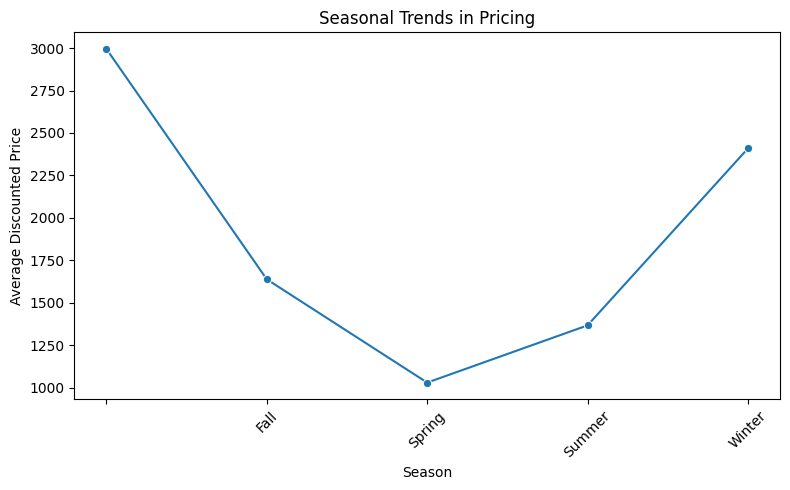

In [42]:
# Calculate the average discounted price by season
seasonal_price = cleaned_df.groupBy("data_season") \
    .agg(F.avg("data_discountedPrice").alias("avg_discounted_price")) \
    .orderBy("data_season")

# Convert to Pandas for visualization
seasonal_price_pd = seasonal_price.toPandas()

# Visualization: Line graph
plt.figure(figsize=(8, 5))
sns.lineplot(data=seasonal_price_pd, x="data_season", y="avg_discounted_price", marker="o")
plt.title("Seasonal Trends in Pricing")
plt.ylabel("Average Discounted Price")
plt.xlabel("Season")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 8] Usage Analysis by Season and Category

In [44]:
# Group by season and usage
season_usage_analysis = cleaned_df.groupBy("data_season", "data_usage").agg(
    count("*").alias("usage_count")
)

# Show the result
season_usage_analysis.orderBy("data_season", "usage_count", ascending=False).show(truncate=False)

+-----------+------------+-----------+
|data_season|data_usage  |usage_count|
+-----------+------------+-----------+
|Winter     |Casual      |7995       |
|Winter     |Formal      |247        |
|Winter     |Sports      |117        |
|Winter     |Ethnic      |105        |
|Winter     |Smart Casual|32         |
|Winter     |Travel      |12         |
|Winter     |NA          |5          |
|Winter     |Party       |5          |
|Winter     |            |1          |
|Summer     |Casual      |16313      |
|Summer     |Sports      |2135       |
|Summer     |Ethnic      |1887       |
|Summer     |Formal      |1079       |
|Summer     |NA          |30         |
|Summer     |Travel      |12         |
|Summer     |Smart Casual|10         |
|Summer     |Party       |10         |
|Spring     |Casual      |2554       |
|Spring     |NA          |270        |
|Spring     |Sports      |110        |
+-----------+------------+-----------+
only showing top 20 rows



## 9]Top Products by Revenue and Season

In [45]:
# Calculate total revenue for each product by season
top_products_season = cleaned_df.groupBy("data_season", "data_productDisplayName").agg(
    sum("data_discountedPrice").alias("total_revenue")
).orderBy("data_season", "total_revenue", ascending=False)

# Show the top products by season
top_products_season.show(truncate=False)

+-----------+----------------------------------------------+-------------+
|data_season|data_productDisplayName                       |total_revenue|
+-----------+----------------------------------------------+-------------+
|Winter     |Nautica Men Black Dial Chronograph Watch      |156435       |
|Winter     |Timex Men Black Dial Watch                    |120140       |
|Winter     |Titan Men White Dial Watch                    |105200       |
|Winter     |Giordano Men Black Dial Watch                 |102528       |
|Winter     |Morellato Men Silver Dial Watch               |83250        |
|Winter     |Fastrack Men Black Dial Watch                 |78745        |
|Winter     |Ed Hardy Men Black Dial Watch                 |74980        |
|Winter     |Citizen Men Black Dial Chronograph Watch      |73200        |
|Winter     |Titan Men Black Dial Watch                    |72930        |
|Winter     |Catwalk Women Black Heels                     |70485        |
|Winter     |Miss Sixty S

## 10] Seasonal and Yearly Distribution of Base Colors in Products

In [46]:
trends_df = cleaned_df.groupBy("data_season", "data_year", "data_baseColour").count()
trends_df.show()

+-----------+---------+---------------+-----+
|data_season|data_year|data_baseColour|count|
+-----------+---------+---------------+-----+
|       Fall|     2012|      Navy Blue|   64|
|     Winter|     2017|          Black|    3|
|     Summer|     2012|      Navy Blue|  586|
|     Summer|     2012|         Purple|  474|
|       Fall|     2018|          White|    3|
|       Fall|     2011|           Blue| 1338|
|     Winter|     2012|   Coffee Brown|    3|
|     Winter|     2011|         Yellow|    3|
|     Spring|     2013|            Red|   14|
|     Winter|     2012|          Brown|  168|
|     Spring|     2013|          Black|   92|
|     Summer|     2014|          Black|   34|
|     Summer|     2015|         Orange|   10|
|     Summer|     2018|          Black|   17|
|     Summer|     2010|         Purple|    7|
|       Fall|     2013|         Purple|    1|
|     Summer|     2011|          Green|  307|
|     Summer|     2008|           Grey|    1|
|     Spring|     2013|         Si

## 11] Multi-Level Revenue and Sales Count by Brand, Style, and Season

In [ ]:
# Calculate revenue by brand, style type, and season
brand_diversification = cleaned_df.groupBy("data_brandName", "data_season", "data_styleType").agg(
    sum("data_discountedPrice").alias("total_revenue"),
    count("*").alias("product_count")
).orderBy("data_brandName", "data_season", "total_revenue", ascending=False)

# Show the results
brand_diversification.show(truncate=False)

## 12]Customer Segmentation by Spending Levels

In [ ]:
# Group customers by total spending
customer_segments = cleaned_df.groupBy("data_id").agg(
    sum("data_discountedPrice").alias("total_spent")
).withColumn(
    "spending_segment",
    when(col("total_spent") > 10000, "High Spender")
    .when(col("total_spent") > 5000, "Medium Spender")
    .otherwise("Low Spender")
).groupBy("spending_segment").agg(
    count("*").alias("customer_count"),
    avg("total_spent").alias("avg_spent")
)

# Show the results
customer_segments.show(truncate=False)

## 13] Pricing Analysis by Gender, Season, and Price Range

In [ ]:
# Group products into price ranges
pricing_analysis = cleaned_df.withColumn(
    "price_range",
    when(col("data_discountedPrice") < 500, "<500")
    .when((col("data_discountedPrice") >= 500) & (col("data_discountedPrice") < 1500), "500-1500")
    .when((col("data_discountedPrice") >= 1500) & (col("data_discountedPrice") < 3000), "1500-3000")
    .otherwise(">3000")
).groupBy("data_gender", "data_season", "price_range").agg(
    count("*").alias("sales_count"),
    sum("data_discountedPrice").alias("total_revenue")
).orderBy("data_gender", "data_season", col("sales_count").desc())

# Show results
pricing_analysis.show(truncate=False)

## 14] Discount Analysis by Range, Sales Count, and Total Revenue

In [ ]:
from pyspark.sql.functions import when, col

# Calculate optimal discount range
discount_analysis = cleaned_df.withColumn(
    "discount_percentage",
    ((col("label") - col("data_discountedPrice")) / col("label")) * 100
).withColumn(
    "discount_range",
    when(col("discount_percentage") < 10, "<10%")
    .when((col("discount_percentage") >= 10) & (col("discount_percentage") < 30), "10-30%")
    .when((col("discount_percentage") >= 30) & (col("discount_percentage") < 50), "30-50%")
    .otherwise(">50%")
).groupBy("discount_range").agg(
    count("*").alias("sales_count"),
    sum("data_discountedPrice").alias("total_revenue")
).orderBy(col("sales_count").desc())

# Show results
discount_analysis.show(truncate=False)

# - Machine Leaning
## ML :- Done by Avirit Singh

In [8]:
cleaned_df = cleaned_df.withColumn("data_year", col("data_year").cast("int"))

In [9]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Step 1: Index Categorical Features
indexer = StringIndexer(inputCols=["data_fashionType", "data_brandName", "data_baseColour"],
                        outputCols=["fashionType_index", "brandName_index", "baseColour_index"])

indexed_df = indexer.fit(cleaned_df).transform(cleaned_df)

# Step 2: Assemble Features into a Vector
assembler = VectorAssembler(
    inputCols=["fashionType_index", "brandName_index", "baseColour_index", "data_price", "data_year"],
    outputCol="features"
)

# Create the final DataFrame
final_df = assembler.transform(indexed_df)

# Display the prepared DataFrame
final_df.select("features", "data_price").show(5)


+--------------------+----------+
|            features|data_price|
+--------------------+----------+
|[0.0,1.0,2.0,4999...|      4999|
|[0.0,86.0,7.0,119...|      1199|
|[0.0,47.0,8.0,159...|      1590|
|[0.0,18.0,0.0,209...|      2099|
|[0.0,18.0,2.0,209...|      2099|
+--------------------+----------+
only showing top 5 rows



In [10]:
# Calculate discount percentage
final_df = final_df.withColumn(
    "discount_percentage",
    when(col("data_price") > 0, (col("data_price") - col("data_discountedPrice")) / col("data_price") * 100).otherwise(0)
)

# Show the updated DataFrame
final_df.select("data_brandName", "data_price", "data_discountedPrice", "discount_percentage").show(5)

+-------------------+----------+--------------------+-------------------+
|     data_brandName|data_price|data_discountedPrice|discount_percentage|
+-------------------+----------+--------------------+-------------------+
|               Puma|      4999|                4999|                0.0|
|SDL by Sweet Dreams|      1199|                1199|                0.0|
|         Timberland|      1590|                1590|                0.0|
|                Lee|      2099|                2099|                0.0|
|                Lee|      2099|                2099|                0.0|
+-------------------+----------+--------------------+-------------------+
only showing top 5 rows



In [11]:
final_df = final_df.withColumnRenamed("data_price", "label")

In [12]:
# Check null counts for the columns used in VectorAssembler
cleaned_df.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in ["data_fashionType", "data_brandName", "data_baseColour", "data_price", "data_year"]]
).show()

# Drop rows where any of the relevant columns are null
cleaned_df = cleaned_df.dropna(subset=["data_fashionType", "data_brandName", "data_baseColour", "data_price", "data_year"])

cleaned_df = cleaned_df.fillna({
    "data_fashionType": "unknown",
    "data_brandName": "unknown",
    "data_baseColour": "unknown",
    "data_price": 0,
    "data_year": 0
})
assembler = VectorAssembler(
    inputCols=["fashionType_index", "brandName_index", "baseColour_index", "data_price", "data_year"],
    outputCol="features",
    handleInvalid="skip"  # Skip rows with nulls
)
assembler = VectorAssembler(
    inputCols=["fashionType_index", "brandName_index", "baseColour_index", "data_price", "data_year"],
    outputCol="features",
    handleInvalid="keep"  # Treat nulls as a separate category
)
final_df = assembler.transform(indexed_df)
final_df.select("features", "data_price")

+----------------+--------------+---------------+----------+---------+
|data_fashionType|data_brandName|data_baseColour|data_price|data_year|
+----------------+--------------+---------------+----------+---------+
|               0|             0|              0|        20|        1|
+----------------+--------------+---------------+----------+---------+



DataFrame[features: vector, data_price: int]

In [13]:
# Rename data_price to label
final_df = final_df.withColumnRenamed("data_price", "label")

In [14]:
final_df.printSchema()

root
 |-- meta_code: integer (nullable = true)
 |-- meta_requestId: string (nullable = true)
 |-- data_id: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- data_discountedPrice: integer (nullable = true)
 |-- data_styleType: string (nullable = true)
 |-- data_productTypeId: integer (nullable = true)
 |-- data_articleNumber: string (nullable = true)
 |-- data_productDisplayName: string (nullable = true)
 |-- data_variantName: string (nullable = true)
 |-- data_myntraRating: integer (nullable = true)
 |-- data_catalogAddDate: integer (nullable = true)
 |-- data_brandName: string (nullable = true)
 |-- data_ageGroup: string (nullable = true)
 |-- data_gender: string (nullable = true)
 |-- data_baseColour: string (nullable = true)
 |-- data_colour1: string (nullable = true)
 |-- data_colour2: string (nullable = true)
 |-- data_fashionType: string (nullable = true)
 |-- data_season: string (nullable = true)
 |-- data_year: integer (nullable = true)
 |-- data_usage: strin

In [15]:
# Check for null or NaN values in the 'label' column
final_df.select(
    count(when(col("label").isNull(), 1)).alias("null_count"),
    count(when(isnan(col("label")), 1)).alias("nan_count")
).show()
# Drop rows with null or NaN values in the label column
final_df = final_df.filter(col("label").isNotNull() & ~isnan(col("label")))
# Replace null or NaN values with 0
final_df = final_df.fillna({"label": 0})

+----------+---------+
|null_count|nan_count|
+----------+---------+
|        20|        0|
+----------+---------+



In [16]:
final_df = final_df.filter(col("label").isNotNull())

# Verify the null count again
final_df.select(
    count(when(col("label").isNull(), 1)).alias("null_count")
).show()

+----------+
|null_count|
+----------+
|         0|
+----------+



In [17]:
def contains_nan_or_inf(vector):
    return any(x != x or x == float('inf') or x == float('-inf') for x in vector.toArray())

contains_nan_or_inf_udf = udf(contains_nan_or_inf, "boolean")

# Filter rows with NaN or Infinity in the features column
problematic_rows = final_df.filter(contains_nan_or_inf_udf(col("features")))

# Show problematic rows

In [18]:
final_df = final_df.filter(~contains_nan_or_inf_udf(col("features")))

In [19]:
# Check again for problematic rows
problematic_rows = final_df.filter(contains_nan_or_inf_udf(col("features")))
print(f"Number of problematic rows: {problematic_rows.count()}")

Number of problematic rows: 0


In [24]:
from pyspark.ml.regression import LinearRegression

# Define Linear Regression model with regularization
lr = LinearRegression(featuresCol="features", labelCol="label", regParam=0.1, elasticNetParam=0.5)

# Fit the model
lr_model = lr.fit(final_df)

# Predict on the dataset
lr_predictions = lr_model.transform(final_df)

# Show predictions
print("========================================== Linear Regression =========================================")
lr_predictions.select("features", "label", "prediction").show(5)

========================================== Linear Regression =========================================
+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[0.0,1.0,2.0,4999...| 4999| 4998.807239194444|
|[0.0,86.0,7.0,119...| 1199|1199.0286754063925|
|[0.0,47.0,8.0,159...| 1590|1590.0058907856367|
|[0.0,18.0,0.0,209...| 2099|2098.9762299877734|
|[0.0,18.0,2.0,209...| 2099|2098.9762299877734|
+--------------------+-----+------------------+
only showing top 5 rows



In [25]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate RMSE
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(lr_predictions)
print(f"Root Mean Square Error (RMSE) Linear Regression: {rmse}")


# Evaluate R²
r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(lr_predictions)
print(f"R² Linear Regression: {r2}")

Root Mean Square Error (RMSE) Linear Regression: 0.0999982838823679


R² Linear Regression: 0.999999996604294


In [26]:
# Print coefficients and intercept
print(f"Coefficients LR: {lr_model.coefficients}")
print(f"Intercept LR: {lr_model.intercept}")

Coefficients LR: [0.0,0.0,0.0,0.9999417273126453,0.0]
Intercept LR: 0.09854435853073856


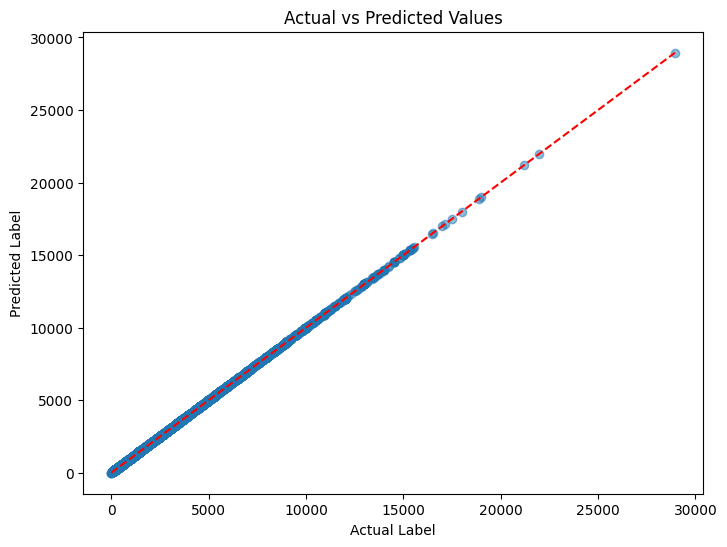

In [27]:
# Convert to Pandas DataFrame
pandas_df = lr_predictions.select("label", "prediction").toPandas()

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(pandas_df["label"], pandas_df["prediction"], alpha=0.5)
plt.plot([pandas_df["label"].min(), pandas_df["label"].max()], [pandas_df["label"].min(), pandas_df["label"].max()], 'r--')
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
plt.title("Actual vs Predicted Values")
plt.show()